In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
import math
import scipy.integrate
import pandas as pd
import seaborn as sb
import sys
sys.path.insert(0, '..')
import cylinder.surfaces_and_fields.system_cylinder as cylinder

firsttime=True

plt.rcParams["figure.figsize"]=6,6
plt.rcParams['font.size'] = '18'

# 1. Limits perturbatively

Plot the linear limit of stability $k_c(\gamma, \kappa)$ obtained from linear stability analysis.

The energy difference is $$ \frac{\delta \mathcal{H}}{A_0 a^2} = \frac{\gamma}{4} (k^2 r^2 -1)+ \frac{\kappa}{8r^2} (3 + (4H_0-1) k^2r^2 + 2 k^4 r^4), $$ setting $r_0 =1$
$$ \frac{\delta \mathcal{H}}{A_0 a^2} = \frac{\gamma}{4} (k^2 -1)+ \frac{\kappa}{8} (3 + (4H_0-1) k^2 + 2 k^4). $$

Solutions are at $$ k_c(g) = \frac{1}{2} \sqrt{1-2g-8h + \sqrt{8(2g-3)+(-1+8h+22g)^2}} $$ with $g=\gamma/\kappa$.

In case of zero spontaneous curvature $h=0$:

$$ k_c(g) = \frac{1}{2} \sqrt{1-2g + \sqrt{8(2g-3)+(-1+22g)^2}}. $$

In [2]:
def kcrit(g,h):
    g+=2*h**2
    discriminant1 =8*(2*g-3)+(-1+8*h+2*g)**2
    #discriminant1 =-23 + 12* g+4 * g**2
    if discriminant1<0:
        return np.nan
    else:
        discriminant2 = 1-2*g-8*h +  math.sqrt(discriminant1)
        #print(discriminant2)
        if discriminant2 <0:
            return np.nan
        else:
            return .5*math.sqrt(discriminant2)

In [3]:
gs = list(np.arange(0.001, 10, .001))
gs.extend([1/kappa for kappa in range(1,10)])
gs.extend( [20,50,100,200,500,1000,10000,100000])
gs.sort()
kcrits_ = [kcrit(g, h=0) for g in gs] #generate data

Plot of limit of instability as a function of rising relative surface tension $\gamma$:

(0.0, 4.0)

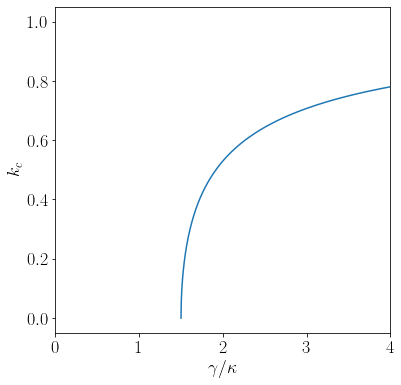

In [4]:
plt.plot([g for g,kc in zip(gs, kcrits_)], [kc for kc in kcrits_])
plt.xlabel(r"$\gamma/\kappa$")
plt.ylabel(r'$k_c$')
plt.xlim(0,4)

Same limit viewed as a function of relative bending rigidity $\kappa$:

(0.0, 1.0)

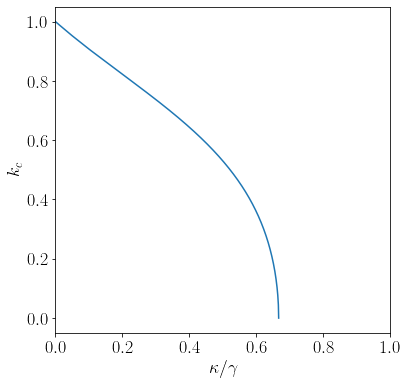

In [5]:
plt.plot([1/g for g,kc in zip(gs, kcrits_)], [kc for kc in kcrits_])
plt.xlabel(r"$\kappa/\gamma$")
plt.ylabel(r'$k_c$')
plt.xlim(0,1)

## 1.2 With Spontaneous curvature

Now try limits of instability with nonzero spontaneous curvatures

(0.0, 10.0)

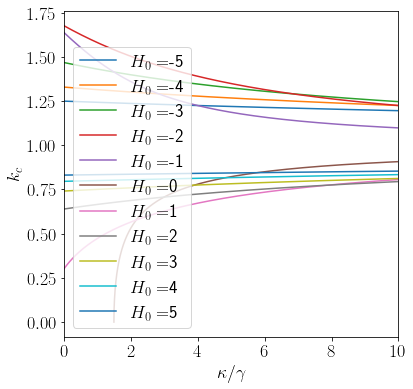

In [6]:
hs = np.arange(-5, 6, 1)
kcrits_h = {} #dict to save all the data
for h in hs:
    kcrits_h[h] = [kcrit(g, h=h) for g in gs]
    plt.plot([g for g in gs], [kc for kc in kcrits_h[h]], label = r'$H_0=$' + str(h))
plt.legend()
plt.xlabel(r"$\kappa/\gamma$")
plt.ylabel(r'$k_c$')
plt.xlim((0,10))

At positive spontaneous curvature $H_0$, the instability is supresses, with longer cylinders (smaller wavenumber $k$) than $k=1$ remaining stable.   Critical bending rigidity remains at the same point $\kappa/\gamma = 3/2$.

At negative spontanous curvatures the cylinder is destablized.

In a $\gamma/\kappa$ view:

(0.0, 1.0)

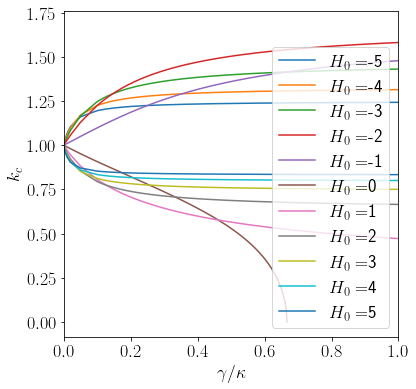

In [7]:
for h in hs:
    plt.plot([1/g for g in gs], [kc for kc in kcrits_h[h]], label = r'$H_0=$' + str(h))
plt.legend()
plt.xlabel(r"$\gamma/\kappa$")
plt.ylabel(r'$k_c$')
plt.xlim((0,1))

Now plot from the angle of varying $H_0$ at some fixed $\gamma/\kappa$

Text(0.5, 0, '$H_0$')

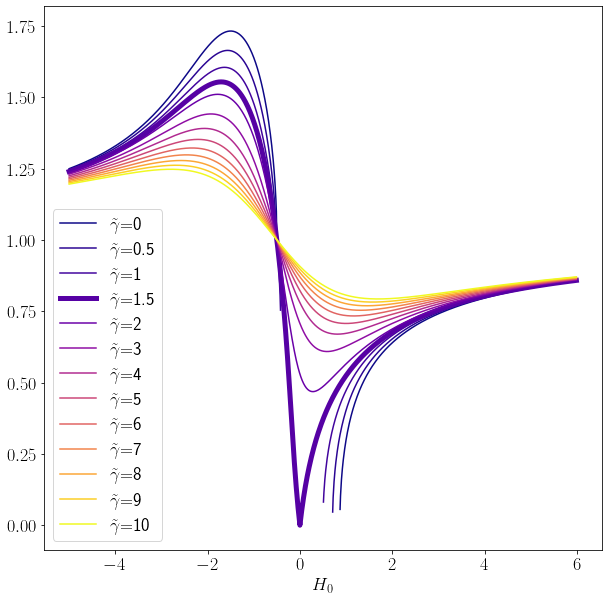

In [8]:
fine_hs = np.arange(-5, 6, .01)
g_ratios = [i for i in np.arange(0,11,1)]
g_ratios.extend([.5,1.5])
g_ratios.sort()
kcrits_rangehs= {} #place to store data
#colorcode
g_ratio_colors = {} 
for g_ratio in g_ratios:
    value=(g_ratio-min(g_ratios))/(max(g_ratios)-min(g_ratios))
    g_ratio_colors[g_ratio]= plt.cm.plasma(value)
    
#plot
plt.figure(figsize=(10,10))    
for g_ratio in g_ratios:
    kcrits_rangehs[g_ratio] = [kcrit(g_ratio,h) for h in fine_hs] #generate data
    if g_ratio == 1.5: #bold the line at critical bending rigidity     
        plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                linewidth=5, c=g_ratio_colors[g_ratio])
    else:
        plt.plot(fine_hs, [kc for kc in kcrits_rangehs[g_ratio]], label = r'$\tilde{\gamma}$=' + str(g_ratio),
                 c=g_ratio_colors[g_ratio])
plt.legend()
plt.xlabel(r"$H_0$")
#plt.ylim(0,2)

# 2. Minima by numerically integrating

For H_0 =0 : we are going to extract energy of the system for a range of k, kappa, a

In [9]:
a_s = np.arange(-.99, 1, .01)
ks = np.arange(0.005, 1.4, .01)

In [ ]:
if firsttime:
    curvenergy = {}
    for k in ks:
        curvenergya={}
        print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=1, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            energy=cy.calc_bending_energy(amplitude=a)
            curvenergya[round(a,2)]=energy
        curvenergy[round(k,4)]=curvenergya
    curvdata = pd.DataFrame(curvenergy)
    curvdata.to_csv("chapter2data/curvenergytens_tmp.csv")
else:
    curvdata=pd.read_csv("chapter2data/curvenergy_H0.csv", index_col=0)
print(curvdata)

0.005
0.015
0.025
0.035
0.045
0.055
0.065
0.075
0.085
0.095
0.105
0.115
0.125
0.135
0.145
0.155
0.165
0.175
0.185
0.195
0.205
0.215
0.225
0.235
0.245
0.255
0.265
0.275
0.285
0.295
0.305
0.315
0.325
0.335
0.345
0.355
0.365
0.375
0.385
0.395
0.405
0.415
0.425
0.435
0.445
0.455
0.465
0.475
0.485
0.495
0.505
0.515
0.525
0.535
0.545
0.555
0.565
0.575
0.585
0.595
0.605
0.615
0.625
0.635
0.645
0.655
0.665
0.675
0.685
0.695
0.705
0.715
0.725
0.735
0.745
0.755
0.765
0.775
0.785
0.795
0.805
0.815
0.825
0.835
0.845
0.855
0.865
0.875
0.885
0.895
0.905
0.915


In [ ]:
if firsttime:
    surfenergy = {}
    for k in ks:
        surfenergya={}
        print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=1, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            energy=cy.evaluate_A_integral_0(amplitude=a)
            surfenergya[round(a,2)]=energy
        surfenergy[round(k,4)]=surfenergya
    #print(surfenergy)
    surfdata = pd.DataFrame(surfenergy)
    print(surfdata)
    surfdata.to_csv("chapter2data/surfenergy_H0_tmp.csv")
else:
    surfdata=pd.read_csv("chapter2data/surfenergy_H0.csv", index_col=0)
print(surfdata)

In [ ]:
for amplitude in np.arange(0,1,.001):
    real_part,error= scipy.integrate.quad(lambda z: cy.A_integrand_real_part(0,amplitude, z), 0, 2 * math.pi /cy.wavenumber)
    real_part_ell = 4.0*cy.radius_rescaled(amplitude)/cy.wavenumber*scipy.special.ellipk(-(amplitude*cy.radius_rescaled(amplitude)*cy.wavenumber)**2)
    print(real_part, real_part_ell, math.isclose(real_part, real_part_ell))

In [ ]:
sb.heatmap(surfdata)

In [ ]:
sb.heatmap(curvdata)

In [ ]:
if firsttime:
    minima_surf = {}
    for k in surfdata.columns:
        energy_vs_a = surfdata.loc[:,k]
        #print(surfdata.loc[:,k])
        min_a = energy_vs_a.idxmin()
        min_energy = energy_vs_a[min_a]
        minima_surf[k]=((min_a, min_energy))
    #print(minima_surf)
    minima_surf_df = pd.DataFrame(minima_surf)
    minima_surf_df.to_csv("chapter2data/minima_surf_tmp.csv")
else:
    minima_surf_df=pd.read_csv("chapter2data/minima_surf.csv")

In [ ]:
if firsttime:
    minima_curv = {}
    for k in curvdata.columns:
        energy_vs_a = curvdata.loc[:,k]
        #print(surfdata.loc[:,k])
        min_a = energy_vs_a.idxmin()
        min_energy = energy_vs_a[min_a]
        minima_curv[k]=((min_a, min_energy))
    #print(minima_curv)
    minima_curv_df=pd.DataFrame(minima_curv)
    minima_curv_df.to_csv("chapter2data/minima_curv_tmp.csv")
else:
    minima_curv_df=pd.read_csv("chapter2data/minima_curv.csv")

In [ ]:
#print(minima_surf_df)
plt.plot([float(k) for k in minima_surf_df.columns], [abs(minima_surf_df.iloc[0,k]) for k in range(len(minima_surf_df.columns))], label="shape amplitude minimizing area")
plt.plot([float(k) for k in minima_curv_df.columns], [abs(minima_curv_df.iloc[0,k]) for k in range(len(minima_curv_df.columns))],label="shape amplitude minimizing curvature energy")
plt.legend()
plt.xlabel("k")
plt.ylabel("|a|")

In [ ]:
plt.plot([float(k) for k in minima_surf_df.columns], [abs(minima_surf_df.iloc[1,k]) for k in range(len(minima_surf_df.columns))], label="minimum area energy")
plt.plot([float(k) for k in minima_curv_df.columns], [abs(minima_curv_df.iloc[1,k]) for k in range(len(minima_curv_df.columns))],label="minimum curvature energy")
plt.legend()
plt.xlabel("k")
plt.ylabel("E")

Let's go through a range of ratios kappa:gamma and find the minimizing amplitude a and energy E at that minimum, for a range of ks

In [ ]:
if firsttime:
    minima_total_as={}
    minima_total_Es={}
    gamma=1
    kappas=np.arange(0,1,.01)
    for kappa in kappas:
        minima_total_as_kappa={}
        minima_total_Es_kappa={}
        for k in curvdata.columns:
            curv_energy_vs_a = curvdata.loc[:,k]
            surf_energy_vs_a = surfdata.loc[:,k]
            total_energy_vs_a = gamma*surf_energy_vs_a+kappa/2*curv_energy_vs_a
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_kappa[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_kappa[k]= min_energy
        minima_total_as[kappa]=minima_total_as_kappa
        minima_total_Es[kappa]=minima_total_Es_kappa
    #print(minima_total)
    df_minima_total_as=pd.DataFrame(minima_total_as)
    df_minima_total_Es=pd.DataFrame(minima_total_Es)
    df_minima_total_as.to_csv("chapter2data/minimizing_a_inkappaandk_tmp.csv")
    df_minima_total_Es.to_csv("chapter2data/minimizing_E_inkappaandk_tmp.csv")
else:
    df_minima_total_as=pd.read_csv("chapter2data/minimizing_a_inkappaandk.csv", index_col=0, dtype=float)
    df_minima_total_Es=pd.read_csv("chapter2data/minimizing_E_inkappaandk.csv", index_col=0, dtype=float)

In [ ]:
sb.heatmap(df_minima_total_as)

In [ ]:
if firsttime:
    minima_total_as_g={}
    minima_total_Es_g={}
    kappa=1
    gammas=np.arange(1,5,.01)
    for gamma in gammas:
        minima_total_as_gamma={}
        minima_total_Es_gamma={}
        for k in curvdata.columns:
            curv_energy_vs_a = curvdata.loc[:,k]
            surf_energy_vs_a = surfdata.loc[:,k]
            total_energy_vs_a = gamma*surf_energy_vs_a+kappa/2*curv_energy_vs_a
            #print(total_energy_vs_a)
            min_a = total_energy_vs_a.idxmin()
            min_energy = total_energy_vs_a[min_a]
            minima_total_as_gamma[k]=abs(min_a)
            #print(min_a)
            minima_total_Es_gamma[k]= min_energy
        minima_total_as_g[gamma]=minima_total_as_gamma
        minima_total_Es_g[gamma]=minima_total_Es_gamma
    df_minima_total_as_g=pd.DataFrame(minima_total_as_g)
    df_minima_total_Es_g=pd.DataFrame(minima_total_Es_g)
    df_minima_total_as_g.to_csv("chapter2data/minimizing_a_ingammaandk_tmp.csv")
    df_minima_total_Es_g.to_csv("chapter2data/minimizing_E_ingammaandk_tmp.csv")
else:
    df_minima_total_as_g=pd.read_csv("chapter2data/minimizing_a_ingammaandk.csv", index_col=0, dtype=float)
    df_minima_total_Es_g=pd.read_csv("chapter2data/minimizing_E_ingammaandk.csv", index_col=0, dtype=float)

In [ ]:
sb.heatmap(df_minima_total_as_g)


Let's make a pretty plot of both views with superimposed pertrubative limit k*

In [ ]:
#we have data: gs, kcrits

y_indices,x_indices = df_minima_total_as.shape
print(df_minima_total_as.shape)
#for lineplot 1 scale date from 0 to .95 to indices 0 to x_indices
lineplot_xs_1= [100*(1/g) for g,kc in zip(gs, kcrits_) if kc is not None]
#for lineplot 1 scale date from 1.395 to 0.005 to indices 0 to y_indices
lineplot_ys_1= [100*(1.395-kc) for kc in kcrits_ if kc is not None]

lineplot_xs_2= [100*(g-1) for g,kc in zip(gs, kcrits_) if kc is not None]
lineplot_ys_2= [100*(1.395-kc) for kc in kcrits_ if kc is not None]

In [ ]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
            gridspec_kw={'width_ratios':[1.2,1.2,0.08]}) #the last axis is for colorbar
#ax1.get_shared_y_axes().join(ax1,ax2)
ax1.plot(lineplot_xs_1, lineplot_ys_1, color='maroon')
ax1.set_ylim([0, 100*1.395])
ax1.set_xlim([0, 100*.99])
g1 = sb.heatmap(df_minima_total_as[::-1],cmap="bone",cbar=False,ax=ax1, vmax=1, vmin=0)
g1.set_ylabel('k')
g1.set_xlabel('kappa/gamma')
g1.set_xticks([n for n in range(0,100,10)])
g1.set_xticklabels([round(.01*n,3) for n in range(0,100,10)])
ax2.plot(lineplot_xs_2, lineplot_ys_2, color='maroon')
g2 = sb.heatmap(df_minima_total_as_g[::-1],cmap="bone",cbar=True, cbar_kws={'label':'|a|'},
                ax=ax2, cbar_ax=axcb, vmax=1, vmin=0)
#g2.set_ylabel('k')
g2.set_xlabel('gamma/kappa')
g2.set_xticks([n for n in range(0,400,50)])
g2.set_xticklabels([round(1+.01*n,3) for n in range(0,400,50)])

g1.set_yticks([n+9 for n in range(0,140,10)])
g1.set_yticklabels([round(1.305-.01*n,3) for n in range(0,140,10)])
g2.set_yticks([])

plt.savefig("chapter2data/numerical_minima_tmp.png")
plt.show()

Let's look at the region around k=1, kappa/gamma=0
kappa=0:  look at just surf_energy_vs_a

In [ ]:
surfdata

In [ ]:
sb.heatmap(surfdata.iloc[:, 90:120])

In [ ]:
range1=90
range2=121
cols = plt.cm.winter([(float(surfdata.columns[k_index])-float(surfdata.columns[range1]))/
                      (float(surfdata.columns[range2-1])-float(surfdata.columns[range1]))  
                      for k_index in range(90,121)])    
for index,k_index in enumerate(range(90,121)):
    k=k_index/100
    k_line=surfdata.iloc[:,k_index]*k
    if k_index%10==0:
        if k_index==100:
            plt.plot(k_line, label="k="+str(surfdata.columns[k_index]), linewidth=5, color='black')
        else:
            plt.plot(k_line, label="k="+str(surfdata.columns[k_index]), linewidth=5, color=cols[index])
    else:
        plt.plot(k_line, linewidth=1,color=cols[index])
plt.xlabel("Shape amplitude a")
plt.ylabel("Surface area")
plt.legend()
plt.ylim(6.2,6.3)
plt.xlim(-.1, .1)
#plt.savefig("./chapter2data/surfarea_discrepancy_tmp.png")
plt.show()

I also want to numerically integrate \int cn^2|A_theta|^2 |Psi_0|^2 dS, the energy from field if it stayed perfectly ordered.  (To first order, the differene in this energy is |alpha|cn^2a^2/2u per unperturbed area). 

In [ ]:
firsttime=True
a_s = np.arange(0, 1, .01)
ks = np.arange(.1, 1.4, .1)
if firsttime:
    straightfieldenergy = {}
    for k in ks:
        straightfieldenergya={}
        print(round(k,4))
        cy=cylinder.Cylinder(wavenumber=k, radius=1, kappa=kappa, gamma=1, intrinsic_curvature=0)
        for a in a_s:
            Ath2sqrtg = lambda z: cy.A_theta(amplitude=a, z=z)**2*cy.sqrt_g_z(amplitude=a, z=z)/cy.sqrt_g_theta(amplitude=a, z=z)
            intAth2, error = scipy.integrate.quad(Ath2sqrtg, 0, 2*math.pi/k) #Ath is real - |A_th| = Ath*Ath/sqrt(gthth)^2
            straightfieldenergya[round(a,2)]=intAth2
        straightfieldenergy[round(k,4)]=straightfieldenergya
    sfdata = pd.DataFrame(straightfieldenergy)
    sfdata.to_csv("chapter2data/straightfieldenergy_tmp.csv")
else:
    sfdata=pd.read_csv("chapter2data/straightfieldenergy.csv", index_col=0)
print(sfdata)


Still need to multiply this by a factor cn^2|sqrt(alpha/u)|^2 (can be taken out of the integral) for the specific field